In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.signal as signal
from scipy.optimize import minimize
from scipy.stats import loguniform, entropy, rv_continuous, uniform, lognorm, norm, halfnorm
from scipy.spatial.distance import jensenshannon
import math

# Tolerance model for filters at different scales

Our hypothesis about how the filters are used in practice will be highlighted here, where each filter at a certain internal scale has a certain tolerance for the scales in the data distribution. 

Using a LogNormal tolerance model and KL divergence we will try to fit the internal scales on the data scale distribution. 


VARIABLES:

- Reference_scale: this is the scale that the smallest internal scale will be placed on (we theorize that this is also variable up to some degree in practice)
- Internal Scales - parameterized by p 
- Sigma's of LogNormal Tolerance Model
- Parameters of data scale distribution


KL Divergence can be calculated using `stats.entropy(pk, qk)`, an alternative to the KL Divergence is the JenssenShannon Divergence. The main difference between these to methods is that KL divergence will punish Q in a region where p is near zero while the Jenssen Shannon Divergence behaves well when both P or Q is small. 

We can fit the two distributions using `stats.optimize.minimize`

We have found that the actual p is much larger than we tought and the distribution is way less peaky, other options are:
- Normal Distribution 
- Chi-Square distribution
- T-Distribution
- Gumbel Distribution
- Cauchy Distribution

Q. How are we going to link the results of the Scale Influence experiment to the tolerance model?
- Use the top-3 performing ISRs for each data distribution to get an estimate of the t-sigma and reference scale
- Our hypothesis is that these values will be similar for all distributions

In [2]:
## Model 

class tolerance_gen(rv_continuous):
    def _pdf(self, x, ref_scale, p, T_sigma, N):
        # Create custom pdf of multivariate lognormal distribution with offset of reference scale
        # x is the vector of values to evaluate the pdf at
        # ref_scale is the reference scale
        # p is the range of the internal scales
        # N is the number of internal scales/number of tolerances
        # T_sigmas is the vector of standard deviations of the tolerance distribution

        # For all lognormal distribution calculate the pdf at x and sum
        pdf = 0
        if type(N) != int:
            N = N[0]
        for i in range(N):
            mu = np.log2(ref_scale * (p ** (i/(N-1))))
            
            # mode_now = np.exp(T_sigma**2)
            # mu = np.log(mode)+T_sigma**2
            # s is the standard deviation of the underlying normal distribution
            # TODO: scale => should vary with location of mode, so that in logspace each distribution has the same width
            pdf_temp = norm.pdf(x, loc=mu, scale=T_sigma)
                                #    scale=np.exp(np.log(mode) + T_sigma**2))
            pdf_temp = pdf_temp / np.max(pdf_temp)
            pdf += pdf_temp
        return pdf / sum(pdf)



In [11]:

import math


def plot_pdfs(whole_range_samples, sample_pdf, bound_l, bound_r, loguniform_a, loguniform_b, ref_scale=1.25, p=2, N=4, T_sigma=0.1, plot_sample_pdf=False, ax = None, legend=True, 
              intermediate_plots=True, plot_tol_model = True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6)) # , dpi=200
        plot_individual = True
    else:
        plot_individual = False

    # xs = np.logspace(np.log(bound_l), np.log(bound_r), 1000, base=np.exp(1))
    xs = whole_range_samples
    # fig, ax = plt.subplots(figsize=(10, 5), dpi=100) # , dpi=200
    
    prob_r = []
    prob_r = tolerance_gen(a=bound_l, b=bound_r, name='tolerance').pdf(xs, ref_scale=ref_scale, p=p, N=N, T_sigma=T_sigma)
    prob_r /= sum(prob_r)
    if plot_sample_pdf:
        ax.plot(xs, sample_pdf, label="Sample PDF", alpha=0.5, zorder=5)
    if plot_tol_model:
        ax.plot(xs, prob_r, label="Tolerance Hypothesis", alpha=1.0, zorder=10)

        for i in range(N):
            mu = np.log2(ref_scale * (p ** (i/(N-1))))
            
            # mode_now = np.exp(T_sigma**2)
            # mu = np.log(mode)+T_sigma**2
            # s is the standard deviation of the underlying normal distribution
            # TODO: scale => should vary with location of mode, so that in logspace each distribution has the same width
            pdf_i = norm.pdf(xs, loc=mu, scale=T_sigma)
            normalization_factor = max(pdf_i) / max(prob_r)
            pdf_i /= normalization_factor
            if intermediate_plots:
                ax.plot(xs, pdf_i, alpha=0.4)

        print("Estimated Parameters - Reference_scale = {:.3f}, p = {:.3f}, T_sigma = {:.3f}".format(ref_scale, p, T_sigma))
        Internal_scales_estimated = [ref_scale * (p**(i/(N-1))) for i in range(N)]
        print("Estimated Internal Scales - ", Internal_scales_estimated)
        for internal_scale in Internal_scales_estimated:
            ax.axvline(np.log2(internal_scale), color='b', linestyle='--', label="Internal Scales")
    
    # prob_lu = loguniform.pdf(xs, a=loguniform_a,b=loguniform_b)
    # prob_lu /= sum(prob_lu)
    ax.axvline(loguniform_a, color='r', linestyle='-.', label = "Data Scale Boundary")
    ax.axvline(loguniform_b, color='r', linestyle='-.', label = "Data Scale Boundary")
    ax.set_xlabel("Scale factor of original MNIST")
    ax.set_ylabel(r"$P(x)$")
    
    # Replace ticks:
    x_ticks_range = np.arange(math.floor(bound_l), math.ceil(bound_r), 1)
    ax.set_xticks(x_ticks_range)
    ax.set_xticklabels([r'$2^{{{}}}$'.format(round(x, 1)) for x in x_ticks_range])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.set_xlim(bound_l, bound_r)
    ax.set_title(f"Log-uniform [{np.exp2(loguniform_a):.0f},{round(np.exp2(loguniform_b),3)}], " + r"$ISR_{hyp}$ = " + f"{p:.2f}")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    if plot_individual:
            plt.savefig(f"/home/markb/Desktop/New Results/tolerance_model_Log-uniform [{np.exp2(loguniform_a):.0f},{round(np.exp2(loguniform_b),3)}].pdf",
            dpi=300,
            bbox_inches='tight')
            plt.show()
    # plt.title(f"Tolerance hypothesis for LogUniform Dist [{np.exp2(loguniform_a):.1f},{np.exp2(loguniform_b):.2f}] with {N} internal scales")
    


In [12]:
def get_data_scale_pdf(whole_range_samples, loguniform_a, loguniform_b, generalization_normal_std):
    data_scale_dist = uniform.pdf(whole_range_samples, loguniform_a, loguniform_b - loguniform_a)
    if generalization_normal_std != 0:
        if generalization_normal_std != 0:
            # Need to normalize peak at bound_l_dist to value of uniform distribution at bound_l_dist
            # Make us of halfnorm distributions instead!
            # Peak value => sqrt(2)/(sigma * sqrt(pi))
            # Set peak value to value of the uniform distribution
            norm_height = math.sqrt(2) / (generalization_normal_std * math.sqrt(math.pi))
            uniform_pdf_height = max(data_scale_dist)
            norm_left = halfnorm.pdf(-whole_range_samples + loguniform_a, 0, scale=generalization_normal_std)
            norm_right = halfnorm.pdf(whole_range_samples, loguniform_b, scale=generalization_normal_std)
            data_scale_dist = data_scale_dist + norm_left*uniform_pdf_height / (norm_height) + norm_right*uniform_pdf_height / (norm_height)
    return data_scale_dist / sum(data_scale_dist)

def estimate_params_joined(N, bound_l, bound_r, log_uniforms_a, log_uniforms_b, initial_guess, p=None, T_sigma=None, ref_scale=None, method='js', generalization_normal_std = 0.1, 
                    nr_samples = 10000, plot_sample_pdf=False, plot_legend = False, intermediate_plots=False):
    bound_l = np.log2(bound_l)
    bound_r = np.log2(bound_r)
    log_uniforms_a = np.log2(log_uniforms_a)
    log_uniforms_b = np.log2(log_uniforms_b)

    whole_range_samples = np.linspace(bound_l, bound_r, nr_samples)
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams.update({'font.size': 14})

    sample_pdfs = []
    for (loguniform_a, loguniform_b) in zip(log_uniforms_a, log_uniforms_b):
        sample_pdf = get_data_scale_pdf(whole_range_samples, loguniform_a, loguniform_b, generalization_normal_std)
        sample_pdfs.append(sample_pdf)
        # combined_data.append(np.random.choice(whole_range_samples, size=10000, p=sample_pdf/sum(sample_pdf)))

    def obj_function_joined(params, method='kl'):
        T_sigma_est = params[-1]
        ref_scale_est_list = params[0:(len(params)-1)//2]
        p_est_list = params[(len(params)-1)//2:-1]
        res = 0
        for Q, ref_scale_est, p_est in zip(sample_pdfs, ref_scale_est_list, p_est_list):
        
            # Calculate KL divergence
            P = tolerance_gen(a=bound_l, b=bound_r, name='tolerance').pdf(whole_range_samples, ref_scale=ref_scale_est if ref_scale is None else ref_scale, p=p_est if p is None else p, N=N, 
                                                                        T_sigma=T_sigma_est if T_sigma is None else T_sigma)
            Q = [1e-100 if q == 0 else q for q in Q]

            temp_res = 0
            if method == 'kl':
                temp_res =  entropy(P, qk=Q)
            elif method == 'js':
                temp_res = jensenshannon(P, Q)
            res += temp_res
        return res
    
    bounds = []
    for i in range(len(log_uniforms_a)):
        bounds.append((0.5, None))
    for i in range(len(log_uniforms_a)):
        bounds.append((1.5, None))
    bounds.append((0.1, None))


    result = minimize(obj_function_joined, initial_guess, method, method='Nelder-Mead', bounds=bounds) # method='Nelder-Mead'
    fitted_params = result.x
    # ref_scale_est_list, p_est_list, T_sigma_est = fitted_params
    T_sigma_est = fitted_params[-1]
    ref_scale_est_list = fitted_params[0:(len(fitted_params)-1)//2]
    p_est_list = fitted_params[(len(fitted_params)-1)//2:-1]
    fig, axs = plt.subplots(ncols=3, figsize=(20, 4), sharex=True) 
    legend = plot_legend
    for ax, sample_pdf, loguniform_a, loguniform_b, ref_scale_est, p_est in zip(axs, sample_pdfs, log_uniforms_a, log_uniforms_b, ref_scale_est_list, p_est_list):
        plot_pdfs(whole_range_samples, sample_pdf, bound_l, bound_r, loguniform_a, loguniform_b, ref_scale=ref_scale_est, p=p_est, T_sigma=T_sigma_est, N=N, plot_sample_pdf=plot_sample_pdf, ax=ax, legend=legend, intermediate_plots=intermediate_plots)
        legend = False 
    plt.savefig("/home/markb/Desktop/New Results/tolerance_hyp_joined.pdf",
            dpi=200,
            bbox_inches='tight')
    plt.show()

def estimate_params(N, bound_l, bound_r, loguniform_a, loguniform_b, initial_guess, p=None, T_sigma=None, ref_scale=None, method='js', generalization_normal_std = 0.1, 
                    nr_samples = 10000, plot_sample_pdf=False, plot_tol_model=True, intermediate_plots=False):
    bound_l = np.log2(bound_l)
    bound_r = np.log2(bound_r)
    loguniform_a = np.log2(loguniform_a)
    loguniform_b = np.log2(loguniform_b)

    whole_range_samples = np.linspace(bound_l, bound_r, nr_samples)
    sample_pdf = get_data_scale_pdf(whole_range_samples, loguniform_a, loguniform_b, generalization_normal_std)
    # plt.plot(whole_range_samples, data_scale_pdf)
    # plt.show()    
    data = np.random.choice(whole_range_samples, size=10000, p=sample_pdf/sum(sample_pdf))

    # data =  uniform.rvs(size=10000, loc=bound_l, scale=bound_r - bound_l)
    # if mollify:
    #     data += norm.rvs(size=10000, loc=0, scale=mollify_sigma) 
    # plt.hist(data)
    # plt.show()
    def obj_function(params, method='kl'):
        ref_scale_est, p_est, T_sigma_est = params
        
        # Calculate KL divergence
        P = tolerance_gen(a=bound_l, b=bound_r, name='tolerance').pdf(whole_range_samples, ref_scale=ref_scale_est if ref_scale is None else ref_scale, p=p_est if p is None else p, N=N, 
                                                                      T_sigma=T_sigma_est if T_sigma is None else T_sigma)
        
        Q = get_data_scale_pdf(whole_range_samples, loguniform_a, loguniform_b, generalization_normal_std)

        # order = np.argsort(data)
        # plt.plot(data[order], Q[order])
        # plt.show()
        # Replace Zero values by a very small value otherwise the Jenssen-Shannon divergence will be INF
        Q = [1e-100 if q == 0 else q for q in Q]

        if method == 'kl':
            return entropy(P, qk=Q)
        elif method == 'js':
            return jensenshannon(P, Q)
        else:
            raise ValueError("Method not supported")

    result = minimize(obj_function, initial_guess, method, method='Nelder-Mead', bounds=((0.5, None), (1.5, None), (0.1, None))) # method='Nelder-Mead'
    fitted_params = result.x

    ref_scale_est, p_est, T_sigma_est = fitted_params
    ref_scale_est = ref_scale_est if ref_scale is None else ref_scale
    p_est = p_est if p is None else p
    T_sigma_est = T_sigma_est if T_sigma is None else T_sigma
    plot_pdfs(whole_range_samples, sample_pdf, bound_l, bound_r, loguniform_a, loguniform_b, ref_scale=ref_scale_est, p=p_est, T_sigma=T_sigma_est, N=N, 
              intermediate_plots = intermediate_plots, plot_sample_pdf=plot_sample_pdf, plot_tol_model=plot_tol_model)


### Tolerance hypothesis on original Scales

Estimated Parameters - Reference_scale = 0.770, p = 2.000, T_sigma = 0.692
Estimated Internal Scales -  [0.7700051279721194, 0.9701456692590689, 1.2223069501638504, 1.5400102559442388]


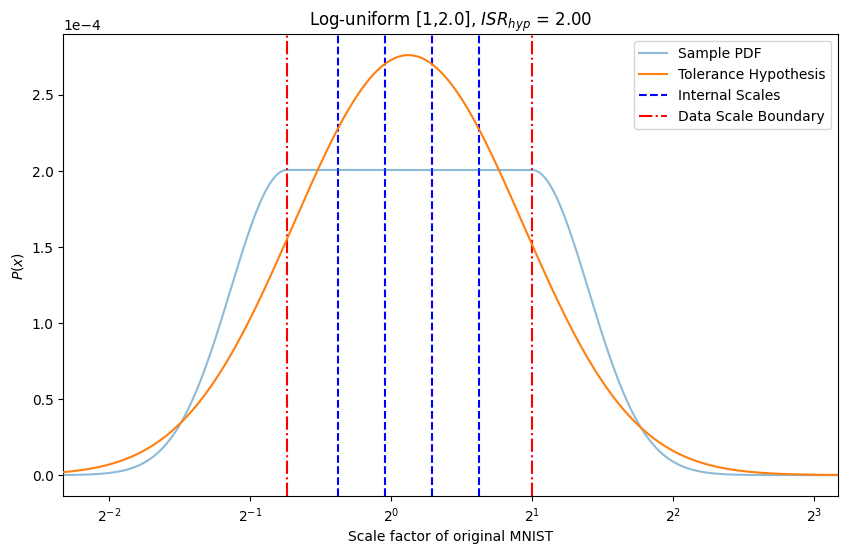

In [8]:

# Estimated Parameters (0.6 - 2, JS) - Reference_scale = 0.775, p = 2.000, T_sigma = 0.213
# Estimated Parameters (0.6 - 2, KL) - Reference_scale = 0.776, p = 2.000, T_sigma = 0.105

estimate_params(N = 4,
                bound_l=0.2,
                bound_r=9,
                loguniform_a=0.6,
                loguniform_b=2,
                initial_guess=[1.25, 2, 0.1],
                p = 2,
                method='kl',
                generalization_normal_std=0.4,
                plot_sample_pdf=True,
                plot_tol_model=True,
                intermediate_plots=False
)


### Tolerance Hypothesis with sigma from SESN/DISCO vs Learned
**Results with T_sigma = 0.213:**
- LogUniform (1,2.83): Estimated Parameters - Reference_scale = 1.245, p = 1.834, T_sigma = 0.213
- LogUniform (1,4.76): Estimated Parameters - Reference_scale = 1.323, p = 2.716, T_sigma = 0.213
- LogUniform (1,8): Estimated Parameters - Reference_scale = 1.524, p = 3.322, T_sigma = 0.213

What's interesting about this:
- However the ratio between 8 and 4.76 (and 4.76 and 2.83) is not the ratio between the learned p values
  - WHY?
    - Fitting is also done with gaps in mind
    - Maybe in reality gaps between internal scales are not that prevalent since they can be moved
    - Probably T_sigma is way larger (indicating wider tolerance) and edges of uniform distribution you are trying to fit not as important
      - Smooth the edges of the Normal distribution somehow?
        - Mollfied Uniform distribution?


**BEST RESULTS with Scale Learning:**
- LogUniform (1,2.83): p => 3.369, basis_min => 2.179 => 0.9748
- LogUniform (1,4.76): p => 3.36, basis_min => 2.20 => 0.9729
- LogUniform (1,8): p => 4.087, basis_min => 2.108 => 0.9692

**BESt Results Different ISRS:**
- LogUniform (1,2.83): p => 2.74 => 0.9749
- LogUniform (1,4.76): p => 4.38=> 0.9727
- LogUniform (1,8): p => 5.13 => 0.9695

Whats interesting about this?
- The learned ISR closely follows the same ratio pattern as the tolerance model! 
- This would indicate that the tolerance model is slightly different than we expect (probably more complex around the edges)
- However (again) the ratio between 8 and 4.76 is not the ratio between the learned p values
  - WHY?
- The learned basis_min_scale for a wider distribution is lower?


Estimated Parameters - Reference_scale = 0.981, p = 2.893, T_sigma = 0.459
Estimated Internal Scales -  [0.9808666727466198, 1.6682362971257823, 2.8372993194426304]
Estimated Parameters - Reference_scale = 1.045, p = 4.319, T_sigma = 0.459
Estimated Internal Scales -  [1.0449170819781592, 2.1715580903182596, 4.512955736831615]
Estimated Parameters - Reference_scale = 1.125, p = 6.320, T_sigma = 0.459
Estimated Internal Scales -  [1.124936178198213, 2.8280887222055067, 7.109812961546268]


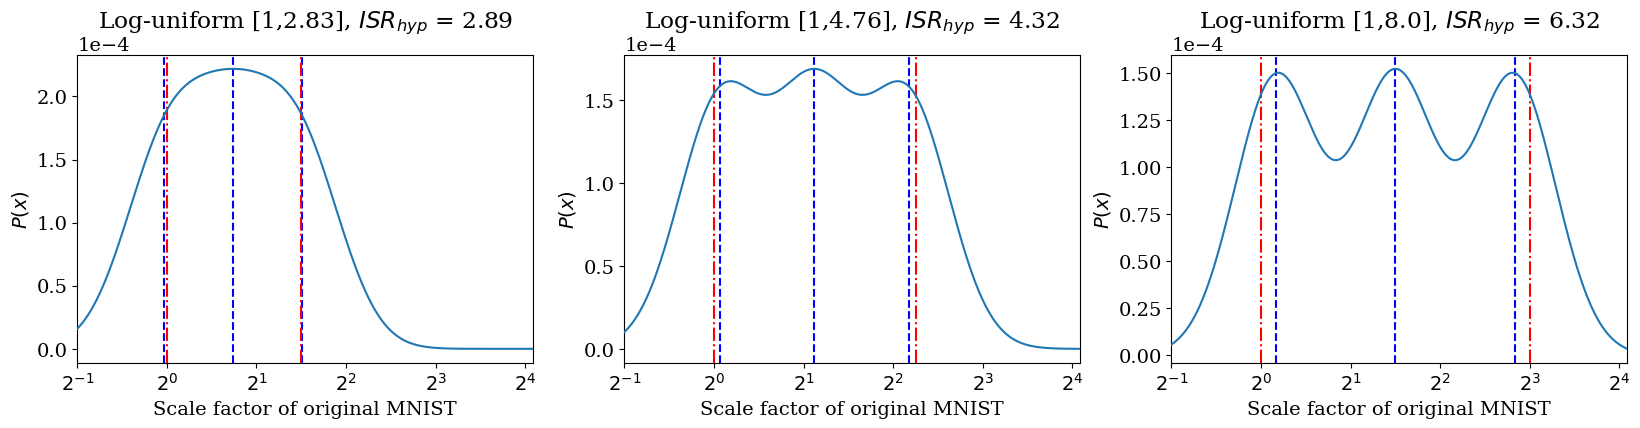

In [14]:
T_sigma = 0.5
bound_l = 0.5
bound_r = 17

estimate_params_joined(N = 3,
                    bound_l=bound_l,
                    bound_r=bound_r,
                    log_uniforms_a=[1,1,1],
                    log_uniforms_b=[2.83, 4.76,8],
                    initial_guess=[1.0, 1.0, 1.0, 2, 2, 2, 0.1],
                    method='kl',
                    generalization_normal_std = 0.4,
                    plot_sample_pdf = False, 
                    plot_legend=False,
                    intermediate_plots=False)


# for dist_range in [(1,4.76), (1,8)]: #, (1,8)
#     estimate_params(N = 3,
#                     bound_l=bound_l,
#                     bound_r=bound_r,
#                     loguniform_a=dist_range[0],
#                     loguniform_b=dist_range[1],
#                     initial_guess=[1.0, 2, 0.1],
#                     method='kl',
#                     # ref_scale=1.25,
#                     T_sigma=T_sigma,
#                     # generalisation_param=0.2,
#                     generalization_normal_std = 0.3,
#                     plot_sample_pdf = True,
#                     # p = 2.78,
#                     # T_sigma=0.138
#     )


### Tolerance Hypothesis (free) vs Learned

In [ ]:

# Results with no T_sigma and plugged in p => T_sigma ~ 0.3:
#   - Results seem to indicate that fitting of uniform distribution at exactly those bounds is not correct (dropoff is probably not that steep). 
T_sigma = None
bound_l = 0.5
bound_r = 12
for p, dist_range in zip([3.36, 4.087], [(1,4.76), (1,8)]):
    estimate_params(N = 3,
                    bound_l=bound_l,
                    bound_r=bound_r,
                    loguniform_a=dist_range[0],
                    loguniform_b=dist_range[1],
                    initial_guess=[1.25, 2, 0.1],
                    method='kl',
                    p = p,
                    T_sigma=T_sigma,
                    generalisation_param=0.4
    )
